# Bike Share Prediction

In [2]:

# Import all required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Supress Warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Import dataset
bikes = pd.read_csv('day.csv')
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# EDA

In [4]:
bikes.shape

(730, 16)

In [5]:
#Null value count and Data type of variables
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
#Unique value present in the variables
bikes.apply(lambda col: col.nunique()).sort_values()

yr              2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
mnth           12
temp          498
hum           594
casual        605
windspeed     649
registered    678
atemp         689
cnt           695
instant       730
dteday        730
dtype: int64

In [7]:
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Sanity check

In [8]:
# check whether count of total rental bikes not including both casual and registered
bikes[((bikes.casual+bikes.registered)!=bikes.cnt)].shape

(0, 16)

In [9]:
#check if weekday is 6 or 0 whether workingday is yes(1)
bikes.loc[((bikes['weekday']==6)|(bikes['weekday']==0))&(bikes['workingday']==1)].shape

(0, 16)

In [10]:
#check if it is a holiday(1) whether workingday is yes(1)
bikes.loc[(bikes['holiday']==1)&(bikes['workingday']==1)].shape

(0, 16)

In [11]:
#Mapping variables season, month, weathersit, weekday

bikes['season']=bikes.season.map({1: 'spring', 2: 'summer',3:'fall', 4:'winter' })
bikes['mnth']=bikes.mnth.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
bikes['weathersit']=bikes.weathersit.map({1: 'Clear',2:'Mist + Cloudy',3:'Light Snow',4:'Snow + Fog'})
bikes['weekday']=bikes.weekday.map({1: 'Wed', 2: 'Thurs', 3: 'Fri', 4: 'Sat', 5: 'Sun', 6: 'Mon', 0: 'Tues'})

bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,Jan,0,Mon,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,Jan,0,Tues,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,Thurs,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# Data Visualization

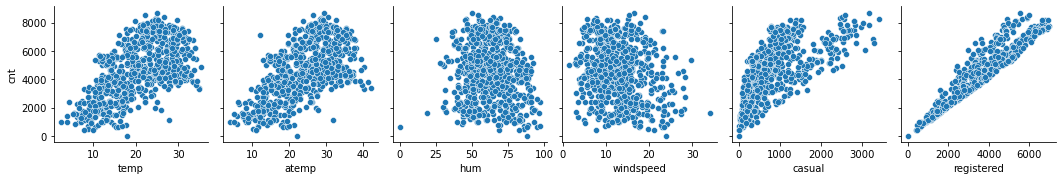

In [12]:
#visualizing the numerical variable.
#check relationship between target variable "cnt" and the predictor variables
sns.pairplot(bikes,y_vars='cnt',x_vars=['temp','atemp','hum','windspeed','casual','registered'])
plt.show()

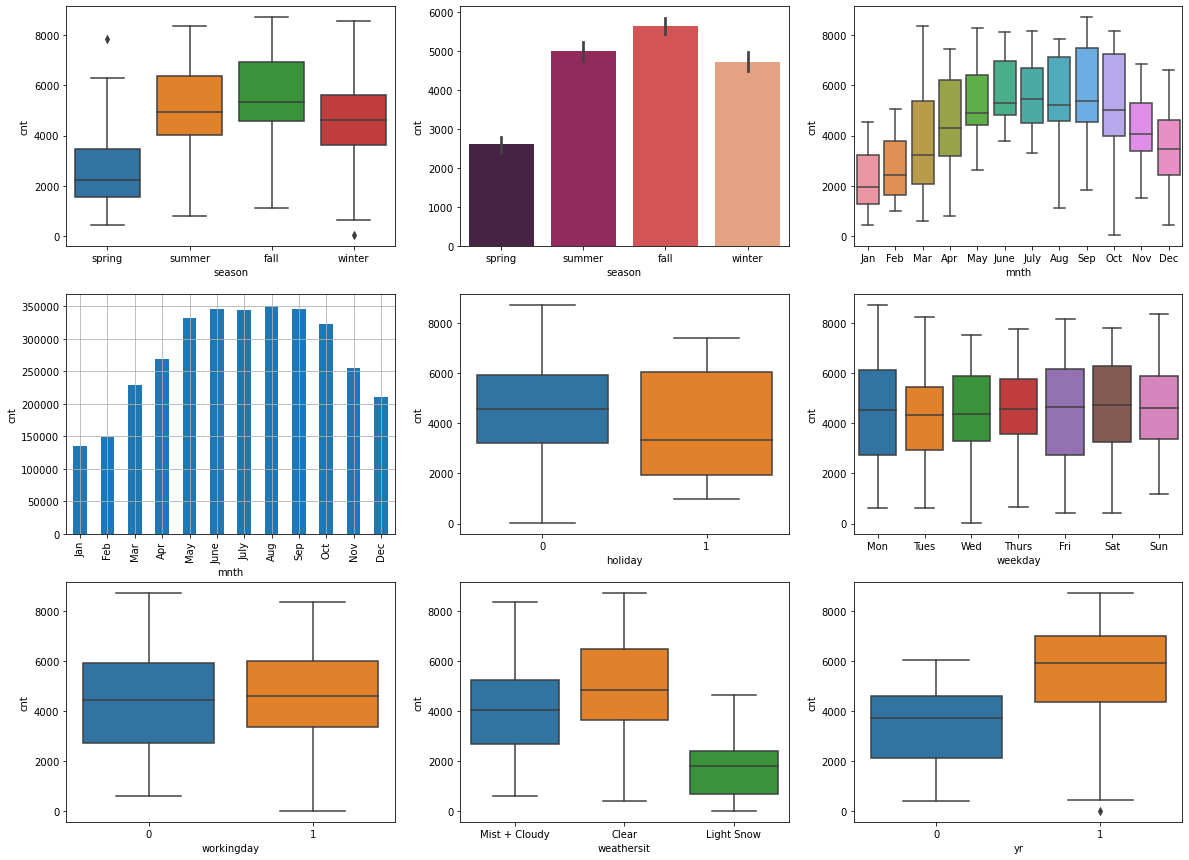

In [13]:
#Visualizing the categorical varible
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
sns.boxplot(x='season',y='cnt',data=bikes)
plt.subplot(3,3,2)
sns.barplot('season','cnt',data=bikes,palette="rocket")
plt.subplot(3,3,3)
sns.boxplot(x='mnth',y='cnt',data=bikes)
plt.subplot(3,3,4)
ax=bikes.groupby(('mnth'),sort=False)['cnt'].sum()
ax=ax.plot.bar()
ax.set_ylabel('cnt')
plt.grid()
plt.subplot(3,3,5)
sns.boxplot(x='holiday',y='cnt',data=bikes)
plt.subplot(3,3,6)
sns.boxplot(x='weekday',y='cnt',data=bikes)
plt.subplot(3,3,7)
sns.boxplot(x='workingday',y='cnt',data=bikes)
plt.subplot(3,3,8)
sns.boxplot(x='weathersit',y='cnt',data=bikes)
plt.subplot(3,3,9)
sns.boxplot(x='yr',y='cnt',data=bikes)
plt.show()

#### Observation:
- Bike rental is more when season is fall then summer and then winter
- Bike rental is more between May to October month.
- Bike rental is more when there is no holiday
- Bike rental is more on Monday, Friday and Saturday.
- Bike rental is more on clear weather.
- Bike rental is more in 2019 compared to 2018.

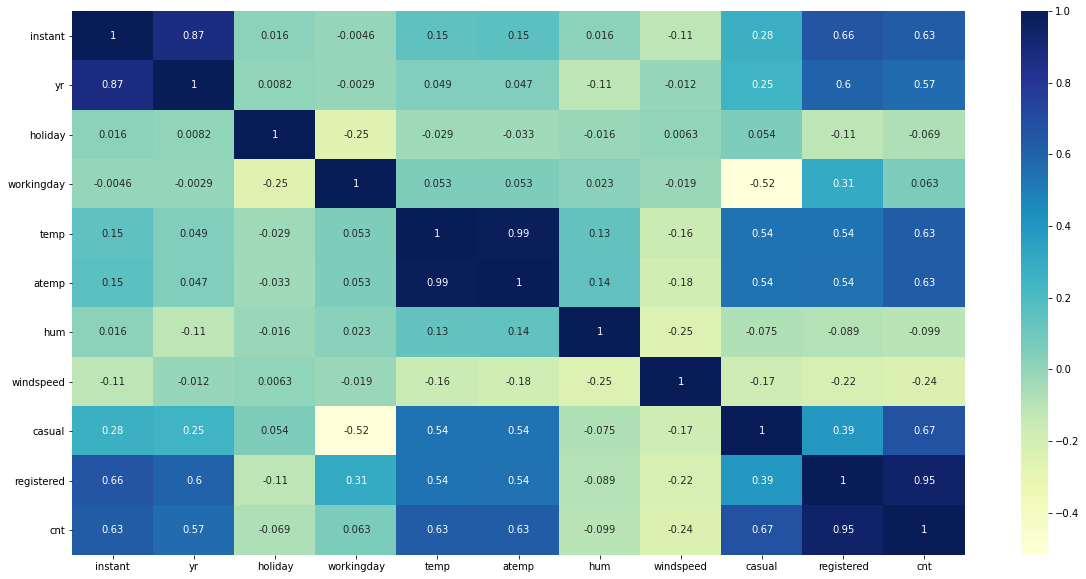

In [14]:
#Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(bikes.corr(),annot=True,cmap="YlGnBu")
plt.show()

Observation:
  - Multicollinearity between registered and cnt, temp and atemp, cnt and casual

# Preparing Data for Modelling.

#### Creating Dummy variables

Example

- Seasons:
     - 000 will corresponds to 1:spring
     - 100 will corresponds to 2:summer
     - 010 will corresponds to 3:fall
     - 001 will corresponds to 4:winter
 

- weathersit:only 3 in the dataset
     - 00 will corresponds to  1: Clear, Few clouds, Partly cloudy, Partly cloudy
     - 10 will corresponds to  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
     - 01 will corresponds to  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

In [15]:
# Creating Dummy Variables and dropping a redundant variable:
seasons = pd.get_dummies(bikes['season'],drop_first=True)
weathers = pd.get_dummies(bikes['weathersit'],drop_first=True)
days = pd.get_dummies(bikes['weekday'],drop_first=True)

In [16]:
#concat the dummy variables column with original dataset
bikes = pd.concat([seasons,weathers,days,bikes],axis=1)
bikes.head()

,spring,summer,winter,Light Snow,Mist + Cloudy,Mon,Sat,Sun,Thurs,Tues,...,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,0,0,1,1,0,0,0,0,...,Mon,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,0,0,1,0,0,0,0,1,...,Tues,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,0,0,0,0,0,0,0,0,...,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,0,0,0,0,0,0,1,0,...,Thurs,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,0,0,0,0,0,0,0,0,...,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [17]:
#Doing label enconding because The number of categories in month is quite large as dummy variable can lead to high memory consumption.
#In Label encoding each label is assigned a unique integer based on alphabetical ordering.
label_encoder = preprocessing.LabelEncoder()
bikes['mnth']= label_encoder.fit_transform(bikes['mnth'])

In [18]:
#Drop the varibles.
#Droping season, weathersit, and weekday because dummy variable is created.
#Droping casual and registered because of target lekage. Droping atemp because of Multicollinearity.
bikes = bikes.drop(['season','weathersit','weekday','instant','dteday','atemp','casual','registered'],axis=1)
bikes.head()

,spring,summer,winter,Light Snow,Mist + Cloudy,Mon,Sat,Sun,Thurs,Tues,Wed,yr,mnth,holiday,workingday,temp,hum,windspeed,cnt
0,1,0,0,0,1,1,0,0,0,0,0,0,4,0,0,14.110847,80.5833,10.749882,985
1,1,0,0,0,1,0,0,0,0,1,0,0,4,0,0,14.902598,69.6087,16.652113,801
2,1,0,0,0,0,0,0,0,0,0,1,0,4,0,1,8.050924,43.7273,16.636703,1349
3,1,0,0,0,0,0,0,0,1,0,0,0,4,0,1,8.200000,59.0435,10.739832,1562
4,1,0,0,0,0,0,0,0,0,0,0,0,4,0,1,9.305237,43.6957,12.522300,1600


## Splitting data into Train and Test

In [27]:
#Split Train data into 70% and Test data in 30%.
df_train,df_test = train_test_split(bikes,train_size=0.7,random_state=100)
print("Train Dataset shape "+str(df_train.shape))
print("Test Dataset shape "+str(df_test.shape))

Train Dataset shape (510, 19)
Test Dataset shape (220, 19)


## Rescaling the features
- Using MinMax scaling

In [28]:
#Instantiate an object
scaler = MinMaxScaler()

#list of numeric variables
var = ['temp','hum','windspeed','cnt']

#Fit on data
df_train[var] = scaler.fit_transform(df_train[var])
df_train.describe()

,spring,summer,winter,Light Snow,Mist + Cloudy,Mon,Sat,Sun,Thurs,Tues,Wed,yr,mnth,holiday,workingday,temp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.243137,0.247059,0.247059,0.029412,0.345098,0.154902,0.133333,0.127451,0.131373,0.143137,0.150980,0.507843,5.523529,0.025490,0.676471,0.537440,0.650480,0.320883,0.513499
std,0.429398,0.431725,0.431725,0.169124,0.475867,0.362166,0.340268,0.333805,0.338139,0.350557,0.358381,0.500429,3.459907,0.157763,0.468282,0.225858,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.518638
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.750000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training the Model

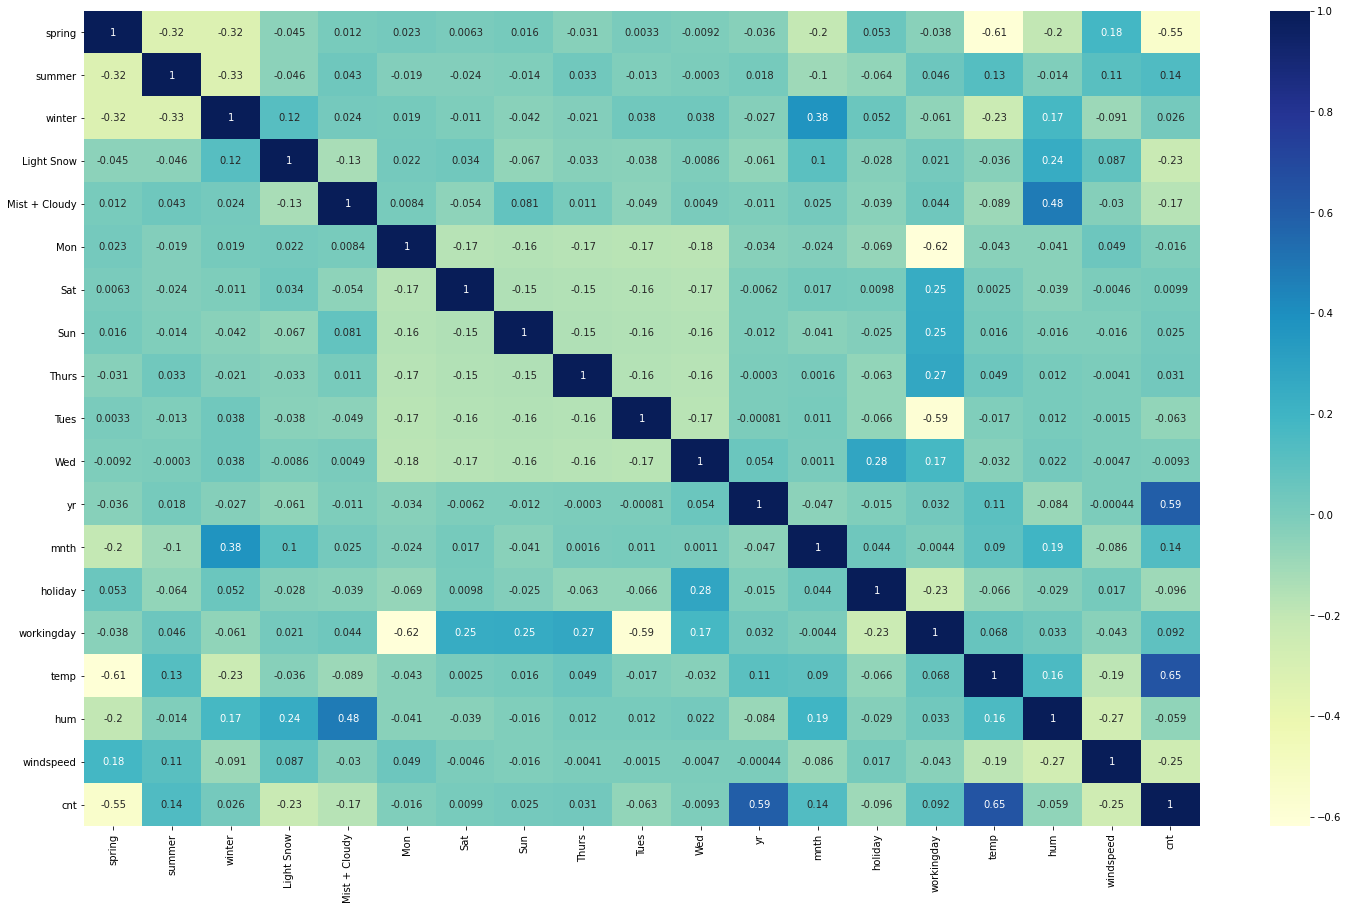

In [29]:
#Heatmap
plt.figure(figsize=(25,15))
sns.heatmap(df_train.corr(),annot=True,cmap="YlGnBu")
plt.show()

In [30]:
# X_train, y_train
y_train = df_train.pop('cnt')
X_train = df_train

576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
         ...   
578    0.832835
53     0.218017
350    0.312586
79     0.236424
520    0.802922
Name: cnt, Length: 510, dtype: float64


In [23]:
# Running RFE with the output number of the variable equal to 8
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,8)
rfe = rfe.fit(X_train,y_train)

In [24]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('spring', True, 1),
 ('summer', False, 5),
 ('winter', False, 2),
 ('Light Snow', True, 1),
 ('Mist + Cloudy', True, 1),
 ('Mon', False, 3),
 ('Sat', False, 9),
 ('Sun', False, 11),
 ('Thurs', False, 8),
 ('Tues', False, 6),
 ('Wed', False, 7),
 ('yr', True, 1),
 ('mnth', False, 10),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [25]:
#Creating X_test dataframe with RFE selected variables
col = X_train.columns[rfe.support_]
X_train = X_train[col]
X_train.head()

,spring,Light Snow,Mist + Cloudy,yr,holiday,temp,hum,windspeed
576,0,0,0,1,0,0.815169,0.725633,0.264686
426,1,0,1,1,0,0.442393,0.640189,0.255342
728,1,0,0,1,0,0.245101,0.498067,0.663106
482,0,0,1,1,0,0.395666,0.504508,0.188475
111,0,0,1,0,0,0.345824,0.751824,0.380981


In [25]:
# function to build model and calculate VIF of the selected variables
def build_model(train_df):
    X_train_sm = sm.add_constant(train_df) # add constant to the dataset.
    model_1 = sm.OLS(y_train,X_train_sm)   #create a model
    model_1 = model_1.fit()                #fit the model
    print(model_1.summary())
    
    #calculate VIF of the variables present in the dataset
    print("---------VIF-----------")
    vif = pd.DataFrame()
    vif['Features']=train_df.columns
    vif['VIF'] = [variance_inflation_factor(train_df.values,i) for i in range (train_df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by = "VIF",ascending = False)
    print(vif)

In [26]:
#build model with RFE selected variables.
build_model(X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     280.9
Date:                Mon, 31 May 2021   Prob (F-statistic):          9.95e-180
Time:                        20:55:05   Log-Likelihood:                 472.93
No. Observations:                 510   AIC:                            -927.9
Df Residuals:                     501   BIC:                            -889.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3848      0.031     12.416

In [27]:
#drop 'hum' because of high VIF and build the model.
X_train = X_train.drop('hum',axis=1)
build_model(X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     316.7
Date:                Mon, 31 May 2021   Prob (F-statistic):          1.26e-179
Time:                        20:55:05   Log-Likelihood:                 469.71
No. Observations:                 510   AIC:                            -923.4
Df Residuals:                     502   BIC:                            -889.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3232      0.019     16.843

# Residual Analysis of the train data

In [28]:
#build the final model with the variable present in the train dataset and predict the target train variable.

X_train_sm = sm.add_constant(X_train) # add constant to the final dataset.
model = sm.OLS(y_train,X_train_sm)    #create a model
model = model.fit()                   #fit the model
y_train_cnt = model.predict(X_train_sm)
res = model.resid                     #residuals 

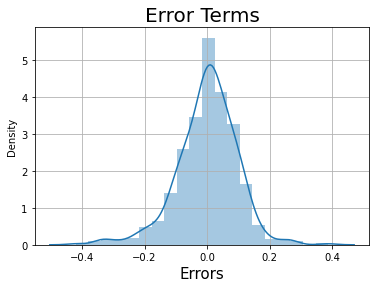

In [29]:
#Plot the histogram of the error terms
fig = plt.figure
sns.distplot((y_train -  y_train_cnt),bins=20)
plt.title("Error Terms",fontsize=20)
plt.xlabel("Errors",fontsize=15)
plt.grid()
plt.show()

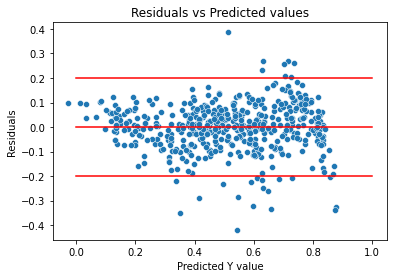

In [30]:
# Check for Homoscedasticity and Independence of Error
p = sns.scatterplot(y_train_cnt,(res))
plt.xlabel('Predicted Y value')
plt.ylabel('Residuals')
p = sns.lineplot([0,1.0],[0,0],color='red')
p = sns.lineplot([0,1.0],[0.2,0.2],color='red')
p = sns.lineplot([0,1.0],[-0.2,-0.2],color='red')
p = plt.title('Residuals vs Predicted values')

# Making Predictions

In [31]:
#Applying scaling on test dataset
test_var = ['temp','hum','windspeed','cnt']

#Fit on data
df_test[test_var] = scaler.transform(df_test[test_var])
df_test.describe()

,spring,summer,winter,Light Snow,Mist + Cloudy,Mon,Sat,Sun,Thurs,Tues,Wed,yr,mnth,holiday,workingday,temp,hum,windspeed,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.254545,0.263636,0.236364,0.027273,0.318182,0.118182,0.163636,0.177273,0.168182,0.145455,0.127273,0.481818,5.477273,0.036364,0.700000,0.558718,0.638221,0.313293,0.522154
std,0.436599,0.441609,0.425817,0.163248,0.466833,0.323559,0.370789,0.382770,0.374881,0.353363,0.334038,0.500809,3.438226,0.187620,0.459303,0.233187,0.148694,0.159584,0.219163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.048205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.355429,0.529197,0.198843,0.378595
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000,0.558172,0.625590,0.300126,0.524678
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,1.000000,0.755981,0.743798,0.402718,0.677750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,0.984424,1.002146,0.807474,0.963300


In [32]:
#create X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test

In [33]:
#Remove columns from X_test which is not present on X_train
X_test = X_test[X_train.columns]

In [34]:
#Adding a constant variable
X_test = sm.add_constant(X_test)
X_test.head()

,const,spring,Light Snow,Mist + Cloudy,yr,holiday,temp,windspeed
184,1.0,0,0,1,0,1,0.831783,0.084219
535,1.0,0,0,0,1,0,0.901354,0.153728
299,1.0,0,0,1,0,0,0.511964,0.334206
221,1.0,0,0,0,0,0,0.881625,0.339570
152,1.0,0,0,0,0,0,0.817246,0.537414


In [35]:
#Making Prediction
y_predict = model.predict(X_test)

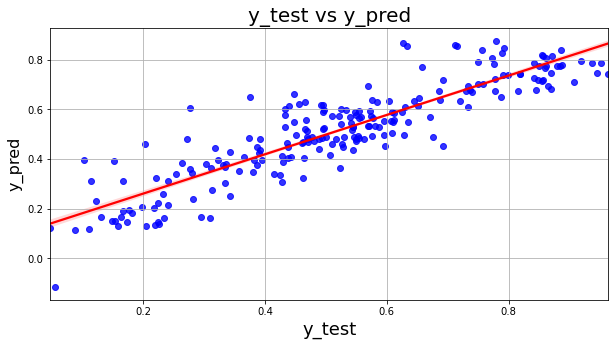

In [36]:
#Regression plot
plt.figure(figsize=(10,5))
sns.regplot(x=y_test, y=y_predict, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=20)            
plt.xlabel('y_test', fontsize=18)                         
plt.ylabel('y_pred', fontsize=16)
plt.grid()
plt.show()

## R-squared score

In [37]:
#R-squared score on the test set
r2_score(y_true=y_test,y_pred=y_predict)

0.7958771639220968

In [38]:
# Adjusted R squared of test set
# Adj R_2 = 1 - ((1 - R2)(N - 1)/ N - P - 1)      
#N = Number of rows in the test dataset; P is number of predictor variables excluding constant.
r2 = r2_score(y_true=y_test,y_pred=y_predict)
adjr2 = 1 - ((1-r2)*(220-1) / (220 - 7- 1))
adjr2

0.7891372589572604

- Train: R squared 0.815; Adjusted R squared 0.813
- Test : R squared 0.796; Adjusted R squared 0.789
- Difference in R squared between Test and Train dataset is 1.9%
- Difference in Adjusted R squared between Test and Train dataset is 2.4%

We can see that the equation of our best fitted line is:

y = 0.3232 + (-0.1530) X spring +  (-0.2736) X Light snow + (-0.0753) X Mist+cloudy + ( 0.2360) X yr  + ( -0.0829) X holiday + (0.3606) X temp + (-0.1558) X windspeed



- We can see that temperature variable is having the highest coefficient 0.4915, which means if the temperature increases by one unit the number of bike rentals increases by 0.4915 units.
- some variables with negative coefficients, A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease. We have spring, light snow, Mist+cloudy, and holiday variables with negative coefficient.

## Interpretation
- We can see demand for bikes was more in 2019 than 2018,So we can assume after the end of Pandemic the business will surely grow.
- BoomBikes focus on Temperature, as Temperature increases in US (From May to September) people uses bikes more.
- On Working day people uses bikes more.
- On Clear weather with less wind people uses bikes more.